Decentralized auctions, under homomorphic encryption and multiparty computation 
============
-----


##  Summary 

The goal of this notebook is to provide a prototype illustrating how homomorphic encryption would allow mechanism design schemes that do not rely on the "mythical central planner". **For instance - auctions ran without an auctioneer acting as trusting third party, but organized by the participating parties themselves** (one can then use such a decentralized auction to automate and improve OTC auctions like those operating under BWIC - "bids wanted in competition" - which are prone to conflicts and misreporting; *see for instance "Public Sector Pension Investment Board of Canada v. Saba Capital Management"*).


## The auction simulation in this notebook 

This notebook provides an illustration of a decentralized auction, which you can run with some of your friends or family members (for now if they are physically located close to you - sorry for the lockdown !). Indeed section 2. below provides a section with hideable cells which each one of you can use to enter his bid. 

To make things more realistic a real (virtual) good can be put on sale here : some of you might indeed know of the blog full of articles on random topics that I have - https://medium.com/@nicolaszhang -, however you couldn't know that there are many "unlisted" articles there that no one without the link can see (see screenshot below).
<img src="Screen%20Shot%202020-05-27%20at207.24.12%20AM.png" />

A pseudo real life auction will then consist in "selling" one of these "unlisted" articles, whose value will be for you (and your friends) to decide. The last section here will offer different auction schemes for this sell, and once you and your friends will decide to participate in, the final winning bidder will be automatically sent a Venmo request with the value of the winning bid. Upon completion of the online transaction the link of the "unlisted" article will be sent to him. 

Our hypothesis will be that the different auction schemes will lead to different winning bids (even among the same players).


## The homomorphic encryption scheme used here 


**Homomorphic encryption refers to a kind of encryption in which some computation on ciphertexts produces an encryption of the desired computation on the plaintexts** (i.e. f(Enc(messages)) = Enc(f(messages)), in which f can be additive, multiplicative, or more sophisticated functions). 

The Paillier encryption scheme used here is for instance homomorphic over the operation of addition. **Namely, given pk, Enc(pk, m1), Enc(pk, m2) one can efficiently compute Enc(pk, m1 + m2)**. *(see Paillier, Pascal (1999). "Public-Key Cryptosystems Based on Composite Degree Residuosity Classes". EUROCRYPT. Springer. pp. 223–238. doi:10.1007/3-540-48910-X_16)*


<img src="Screen%20Shot%202020-04-04%20at%2010.13.52%20PM.png" /> 

<img src="Screen%20Shot%202020-05-27%20at206.55.34%20AM.png" />
<img src="Screen%20Shot%202020-05-27%20at206.55.54%20AM.png" />


In [1]:
# Importing the Paillier encryption library from https://python-paillier.readthedocs.io

from phe import paillier

# Importing a graphic toolbox to plot the distributions in BWIC auctions
import matplotlib.pyplot as plt


In [2]:
# Now we are starting to build the public and private keys

public_key, private_key = paillier.generate_paillier_keypair()
 
# If we’re going to have lots of private keys lying around, then we can use a keyring on which to store our PaillierPrivateKey instances:
keyring = paillier.PaillierPrivateKeyring()
keyring.add(private_key)

In [3]:
# Let's decide how many players we want. 
# For now let's say 3. If you want more you can just copy paste the code below by adding the number of player 4, player 5, etc

# Let's create for all 3 of them a public key and private key pair :

public_key1, private_key1 = paillier.generate_paillier_keypair(keyring)
public_key2, private_key2 = paillier.generate_paillier_keypair(keyring)
public_key3, private_key3 = paillier.generate_paillier_keypair(keyring)

# And the list that will receive their three bids :

secret_number_list = [None] * 3

# We are now starting to enter the bids for the good. 

Here below the cells are collapsable, so that each of your 3 friends can "open" a cell, input their private values in it, then "close" the cell to prevent other players to easily see the value it contains

In [4]:
# Call your friend player 1 and let him enter his bid here (without looking at his value !)

bid_from_player_1 = 13.141592653;

# Let's store that bid in the list of bids
secret_number_list[0] = bid_from_player_1

In [5]:
# Now call your friend player 2 and let him enter his bid here (without looking at his value !)

bid_from_player_2 = 10;

# Let's store that bid in the list of bids
secret_number_list[1]=bid_from_player_2

In [6]:
# Now call your friend player 3 and let him enter his bid here (without looking at his value !)

bid_from_player_3 = 8;

# Let's store that bid in the list of bids
secret_number_list[2]=bid_from_player_3

In [7]:
# Let's now encrypt everything

encrypted_number_list = [public_key.encrypt(x) for x in secret_number_list]
print(encrypted_number_list)
# Now the list of bids has been encrypted using the public key ! It can for instance be revealed without any outside agent being able to decrypt it

[<phe.paillier.EncryptedNumber object at 0x1167ef190>, <phe.paillier.EncryptedNumber object at 0x116767a10>, <phe.paillier.EncryptedNumber object at 0x115df1e10>]


# A "decentralized auctioneer"

This party does not have access to the private keys, and typically performs operations on supplied encrypted data.

Once this party has received some EncryptedNumber instances, it can perform basic mathematical operations supported by the Paillier encryption, such as:

- Addition of an EncryptedNumber to a scalar
- Addition of two EncryptedNumber instances
- Multiplication of an EncryptedNumber by a scalar

In [8]:
#Let's print out the encrypted number for instance to see that they are indeed "meaningless"

encrypted_number_list

In [9]:
# Let's now see homomorphically (i.e. performing the comparison function on the encrypted data) which one of the bids is higher

bid1_vs_bid2 = encrypted_number_list[0] - encrypted_number_list[1]

# You can see that the result is also encrypted, hence meaningless for the outside agent looking at it
print(bid1_vs_bid2)

## With homomorphic encryption, a piece of code (or a "smart contract") can now perform the role of the auctioneer

Such a code does not have access to the private keys, but can still perform operations on supplied encrypted data, and hence tell all participating agents which one has the highest bid (if in a single round auction), or provide some information between rounds before the bid updating step in a multiround auction (the distribution of bids at each round, the distribution *without the highest bid* at each round...)...

This guarantees truthfulness of the auctioneer, full and transparent reporting of the informations that has been decided to be revealed at the end of each round, and better privacy for the bidders on the rest.

### Example of a single round first-price auction based on the previous 3 bids :

In [10]:
if private_key.decrypt(bid1_vs_bid2)>0:
    bid2_vs_bid3 = encrypted_number_list[0] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        print('bidder 1 won the auction')
    else:
        print('bidder 3 won the auction')
        
else:
    bid2_vs_bid3 = encrypted_number_list[1] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        print('bidder 2 won the auction')
    else:
        print('bidder 3 won the auction')
    
        

bidder 1 won the auction


### Example of a multiround BWIC auction based on the previous 3 bids :

Each round of the BWIC auction will be based on two steps : first the submission (or the update) of each one's bid, second the revelation of the distribution of the bids **without the highest bid**.

#### Use the cell below for the submission (or the update) of each one's bid at each round

Here below the cells are collapsable, so that each of your 3 friends can "open" a cell, input their private values in it, then "close" the cell to prevent other players to easily see the value it contains

In [11]:
# Call your friend player 1 and let him enter his bid here (without looking at his value !)

bid_from_player_1 = 13.141592653;

# Let's store that bid in the list of bids
secret_number_list[0] = bid_from_player_1

In [12]:
# Now call your friend player 2 and let him enter his bid here (without looking at his value !)

bid_from_player_2 = 13.141592653;

# Let's store that bid in the list of bids
secret_number_list[1] = bid_from_player_2

In [13]:
# Finally call your friend player 3 and let him enter his bid here (without looking at his value !)

bid_from_player_3 = 13.141592653;

# Let's store that bid in the list of bids
secret_number_list[2] = bid_from_player_3

#### Use the cell below to produce the distribution of the bids without the highest bid at the end of each round

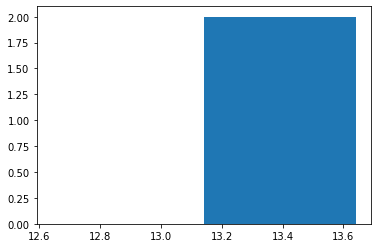

In [14]:
encrypted_number_list = [public_key.encrypt(x) for x in secret_number_list]

bid_distribution_without_highest = [None] * 2
bid1_vs_bid2 = encrypted_number_list[0] - encrypted_number_list[1]

if private_key.decrypt(bid1_vs_bid2)>0:
    bid2_vs_bid3 = encrypted_number_list[0] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        
        #if we were in a single round then print('bidder 1 won the auction') 
        bid_distribution_without_highest[0] = secret_number_list[1]
        bid_distribution_without_highest[1] = secret_number_list[2]
    else:
        #if we were in a single round then print('bidder 3 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[1]
        
else:
    bid2_vs_bid3 = encrypted_number_list[1] - encrypted_number_list[2]
    if private_key.decrypt(bid2_vs_bid3)>0:
        #if we were in a single round then print('bidder 2 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[2]
    else:
        #if we were in a single round then print('bidder 3 won the auction')
        bid_distribution_without_highest[0] = secret_number_list[0]
        bid_distribution_without_highest[1] = secret_number_list[1]
        
plt.hist(bid_distribution_without_highest, bins = 2)
plt.show()
